#### Importing the libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

#### Import dataset & extract dependent & independent variables

In [68]:
salary_data=pd.read_csv('Salary_Data.csv')
x=salary_data.iloc[:,:-1].values
y=salary_data.iloc[:,1].values

In [69]:
salary_data

Years_of_Experience  Salary
0                 2.00   38000
1                 1.50   28500
2                 2.50   47500
3                 3.75   71250
4                 3.25   61750
5                 4.50   85500
6                 2.25   42750

#### Visualising the dataset

<AxesSubplot:xlabel='Years_of_Experience'>

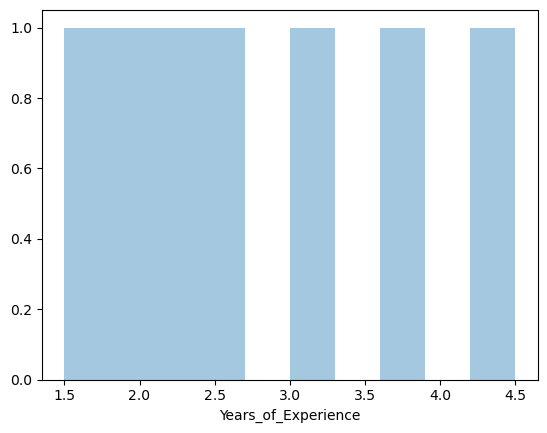

In [72]:
sns.distplot(salary_data['Years_of_Experience'],kde=False,bins=10)

<AxesSubplot:xlabel='count', ylabel='Years_of_Experience'>

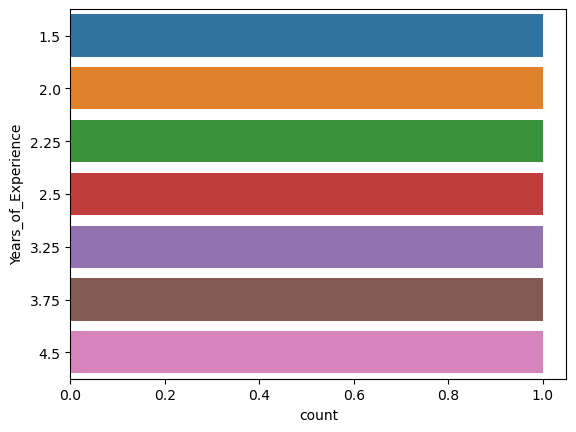

In [73]:
sns.countplot(y='Years_of_Experience',data=salary_data)

<AxesSubplot:xlabel='Years_of_Experience', ylabel='Salary'>

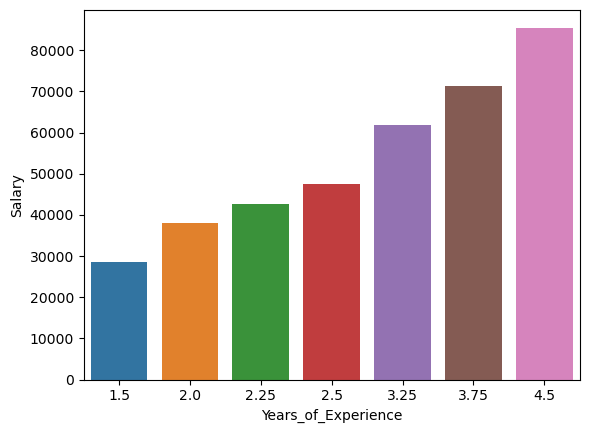

In [75]:
sns.barplot(x='Years_of_Experience',y='Salary',data=salary_data)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader

# Step 1: Data Preparation - Assume you have a dataset class named 'CustomDataset'

class CustomDataset(torch.utils.data.Dataset):
    def _init_(self, data):
        self.data = data

    def _getitem_(self, index):
        # Implement data loading logic here
        return self.data[index]

    def _len_(self):
        return len(self.data)

# Step 2: Feature Extraction - Use a pre-trained CNN for feature extraction

class FeatureExtractor(nn.Module):
    def _init_(self):
        super(FeatureExtractor, self)._init_()
        self.cnn = nn.Sequential(*list(resnet18(pretrained=True).children())[:-1])

    def forward(self, x):
        return self.cnn(x)

# Step 3: Metric Learning - Implement a custom metric learning module

class MetricLearning(nn.Module):
    def _init_(self, input_dim, output_dim):
        super(MetricLearning, self)._init_()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

# Step 4: Prototype Construction

def compute_prototypes(support_set):
    class_prototypes = {}
    for data in support_set:
        features, label = data['features'], data['label']
        if label not in class_prototypes:
            class_prototypes[label] = features
        else:
            class_prototypes[label] += features
    for label in class_prototypes:
        class_prototypes[label] /= len(support_set)
    return class_prototypes

# Step 5: Classification

def classify_examples(query_set, class_prototypes, metric_model):
    predictions = []
    for data in query_set:
        features = data['features']
        similarity_scores = {}
        for label, prototype in class_prototypes.items():
            similarity_scores[label] = torch.cosine_similarity(features, prototype)
        predicted_label = max(similarity_scores, key=similarity_scores.get)
        predictions.append(predicted_label)
    return predictions

# Step 6: Evaluation and Fine-tuning - You can add your own evaluation and fine-tuning logic here

# Example usage:

# Create custom datasets
support_data = [{'features': support_features_1, 'label': label_1}, ...]
query_data = [{'features': query_features_1}, ...]

support_dataset = CustomDataset(support_data)
query_dataset = CustomDataset(query_data)

# Create data loaders
support_loader = DataLoader(support_dataset, batch_size=16, shuffle=True)
query_loader = DataLoader(query_dataset, batch_size=16, shuffle=False)

# Initialize models
feature_extractor = FeatureExtractor()
metric_model = MetricLearning(input_dim=512, output_dim=128)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(metric_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    for batch in support_loader:
        inputs, labels = batch['features'], batch['label']
        
        optimizer.zero_grad()
        
        # Forward pass
        features = feature_extractor(inputs)
        embeddings = metric_model(features)
        
        # Compute loss
        loss = criterion(embeddings, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

# Compute class prototypes
class_prototypes = compute_prototypes(support_data)

# Perform classification on query examples
predictions = classify_examples(query_data, class_prototypes, metric